In [ ]:
rsync -avzhe ssh \
conchae@garnatxa.srv.cpd:/home/conchae/prediction_depolymerase_tropism/prophage_prediction/depolymerase_decipher/ficheros_28032023/train_nn/ensemble_0702 \
/media/concha-eloko/Linux/PPT_clean/ficheros_28032023/

rsync -avzhe ssh \
conchae@garnatxa.srv.cpd:/home/conchae/prediction_depolymerase_tropism/prophage_prediction/depolymerase_decipher/ficheros_28032023/dico_full_seed.joblib \
/media/concha-eloko/Linux/PPT_clean/ficheros_28032023/

In [1]:
from torch_geometric.data import HeteroData, DataLoader
import torch_geometric.transforms as T
from torch_geometric.nn import to_hetero , HeteroConv , GATv2Conv
from torch_geometric.utils import negative_sampling
from torch_geometric.loader import LinkNeighborLoader
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder , label_binarize , OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score , matthews_corrcoef
from sklearn.metrics import roc_curve, auc

import TropiGAT_functions 
import TropiGAT_models
#from TropiGAT_functions import get_top_n_kltypes ,clean_print 

import os
import json
import pandas as pd
import numpy as np
from tqdm import tqdm
from itertools import product
import random
from collections import Counter
import warnings
import logging
import joblib
from multiprocessing.pool import ThreadPool
warnings.filterwarnings("ignore")

# *****************************************************************************
# Load the Dataframes :
path_work = "/media/concha-eloko/Linux/PPT_clean"
path_ensemble = f"{path_work}/ficheros_28032023/winning_ensemble_0702"
path_graph_data = f"{path_work}/ficheros_28032023/training_data_1302"
#path_ensemble = f"{path_work}/ficheros_28032023/ensemble_tailored_0612"


/media/concha-eloko/Linux/conda_envs/torch_geometric/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


> Make models and eval data : 

In [9]:
def get_training_data(kltype) :
    graph_eval = None
    for file in os.listdir(path_graph_data) :
        if file.split("__")[0] == kltype :
            graph_eval = torch.load(f'{path_graph_data}/{file}')
            break
    return graph_eval

@torch.no_grad()
def local_evaluate(model, graph, mask):
    model.eval()
    out_eval  = model(graph)
    logging.info(mask.shape)
    pred = out_eval[mask]
    pred = torch.sigmoid(pred)
    labels = graph["B1"].y[mask]
    return (labels, pred) 

def make_solo_TropiGAT(path_ensemble, target_KL_type):
    errors = []
    DF_info = pd.read_csv(f"{path_work}/TropiGATv2.final_df_v2.filtered.tsv", sep="\t", header=0)
    DF_info_lvl_0 = DF_info.copy()
    df_prophages = DF_info_lvl_0.drop_duplicates(subset=["Phage"])
    dico_prophage_count = dict(Counter(df_prophages["KL_type_LCA"]))
    target_model = None
    for GNN_model in os.listdir(path_ensemble):
        if GNN_model[-2:] == "pt":
            KL_type = GNN_model.split(".")[0]
            if target_KL_type == KL_type:
                try:
                    if dico_prophage_count[KL_type] >= 125:
                        model = TropiGAT_models.TropiGAT_big_module(hidden_channels=1280, heads=1)
                    else:
                        model = TropiGAT_models.TropiGAT_small_module(hidden_channels=1280, heads=1)
                    model.load_state_dict(torch.load(f"{path_ensemble}/{GNN_model}"))
                    target_model = model
                    break
                except Exception as e:
                    a = (KL_type, dico_prophage_count[KL_type], e)
                    errors.append(a)
    return target_model, errors


def evaluate_threshold(y_true, probabilities, threshold):
    predicted_labels = (probabilities >= threshold).astype(int)    
    mcc = matthews_corrcoef(y_true, predicted_labels)    
    return mcc

def optimize_threshold(y_true, probabilities):
    thresholds = np.linspace(0, 1, 100)    
    y_true,  probabilities = y_true, probabilities
    mcc_scores = [evaluate_threshold(y_true, probabilities, threshold) for threshold in thresholds]
    optimal_threshold = thresholds[np.argmax(mcc_scores)]
    max_mcc = max(mcc_scores)
    
    return optimal_threshold, max_mcc    

In [3]:
KL_types = [file.split(".")[0] for file in os.listdir(path_ensemble)]

In [4]:
DF_info = pd.read_csv(f"{path_work}/TropiGATv2.final_df_v2.filtered.tsv", sep = "\t" ,  header = 0)
DF_info_lvl_0 = DF_info.copy()
df_prophages = DF_info_lvl_0.drop_duplicates(subset = ["Phage"])
dico_prophage_count = dict(Counter(df_prophages["KL_type_LCA"]))

> Make prediction and collect the outputs :

***
### Get optimal threshold :

> Open the data : 

In [5]:
data_seed = joblib.load(f"{path_work}/ficheros_28032023/dico_full_seed.joblib")

In [6]:
data_seed

{'KL30': {1: {'predictions': [0.452486127614975,
    0.9579046964645386,
    0.13287286460399628,
    0.49764034152030945,
    0.022287437692284584,
    0.5542023777961731,
    0.028086695820093155,
    0.09751523286104202,
    0.030412660911679268,
    0.029543956741690636,
    0.1485864669084549,
    0.1485864669084549,
    0.03278939798474312,
    0.028830694034695625,
    0.028830694034695625,
    0.08088526129722595,
    0.03919394686818123,
    0.05413340777158737,
    0.05413340777158737,
    0.06827772408723831,
    0.024931082502007484,
    0.9999221563339233,
    0.044852763414382935,
    0.03514931723475456,
    0.10134288668632507,
    0.10134288668632507,
    0.10134288668632507,
    0.019004687666893005,
    0.055443890392780304,
    0.9810624718666077,
    0.06839554756879807,
    0.9484272003173828,
    0.22157660126686096,
    0.046778030693531036,
    0.11605415493249893,
    0.02520412765443325,
    0.05999553203582764,
    0.06107773631811142,
    0.3906339704990387

In [10]:
dico_optimal_seeded = {}

for kltype in data_seed :
    tmp_seed_dico = {}
    for seed in data_seed[kltype] :
        optimal_threshold_seed, max_mcc = optimize_threshold(data_seed[kltype][seed]["labels"], data_seed[kltype][seed]["predictions"])
        tmp_seed_dico[seed] = {"threshold" : optimal_threshold_seed, "mcc" : max_mcc}
    dico_optimal_seeded[kltype] = tmp_seed_dico

In [12]:
optimal_t = {}

for kltype in dico_pred_out :
    optimal_threshold, max_mcc = optimize_threshold(dico_pred_out[kltype]["y_true"], dico_pred_out[kltype]["y_pred"])
    a = {"optimal_MCC" : max_mcc, 
         "optimal_t" : optimal_threshold}
    optimal_t[kltype] = a


In [11]:
def clean_print(dico) :
	""" 
	Inputs : a dico
	Outputs : pretty printed dico
	"""
	import pprint
	pp = pprint.PrettyPrinter(width = 100, sort_dicts = True, compact = True)
	out = pp.pprint(dico)
	return out 

clean_print(dico_optimal_seeded)

{'KL1': {1: {'mcc': 0.8105263157894737, 'threshold': 0.2828282828282829},
         2: {'mcc': 0.7473684210526316, 'threshold': 0.25252525252525254},
         3: {'mcc': 0.5825248321362804, 'threshold': 0.29292929292929293},
         4: {'mcc': 0.783880147156683, 'threshold': 0.23232323232323235},
         5: {'mcc': 0.7219948723811555, 'threshold': 0.24242424242424243}},
 'KL10': {1: {'mcc': 0.6662864061573012, 'threshold': 0.8080808080808082},
          2: {'mcc': 0.6305926250944657, 'threshold': 0.595959595959596},
          3: {'mcc': 0.5963118382339874, 'threshold': 0.5151515151515152},
          4: {'mcc': 0.6324555320336759, 'threshold': 0.8282828282828284},
          5: {'mcc': 0.7378647873726218, 'threshold': 0.5555555555555556}},
 'KL102': {1: {'mcc': 0.900137741046832, 'threshold': 0.9797979797979799},
           2: {'mcc': 0.8978856141885939, 'threshold': 0.696969696969697},
           3: {'mcc': 0.8981462390204986, 'threshold': 0.9797979797979799},
           4: {'mcc': 0.9

In [16]:
for kltype in KL_types :
    transparency = (dico_prophage_count[kltype] / 1121)*100
    dico_pred_out[kltype].update({"transparency" : transparency})

In [9]:
dico_pred_out

{'KL105': {'y_true': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0,
          0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0]),
  'y_pred': tensor([0.1187, 0.0291, 0.0203, 0.0203, 0.0178, 0.1468, 0.2266, 0.2266, 0.0447,
          0.0263, 0.0303, 0.0505, 0.0402, 0.0478, 0.0197, 0.0209, 0.0161, 0.0161,
          0.0161, 0.7798, 0.7798, 0.0122, 0.0118, 0.0086, 0.0099, 0.0099, 0.0328,
          0.0083, 0.0466, 0.0144, 0.0094, 0.1342, 0.0526, 0.2889, 0.8542, 0.0191,
          0.7962, 0.0131, 0.0220, 0.9828, 0.9828, 0.6887, 0.0721, 0.1106, 0.0113,
          0.7403, 0.6206, 0.0184, 0.0113, 0.9962, 0.9924, 0.0340, 0.0683, 0.1808,
          0.0280, 0.0152, 0.0202, 0.0178, 0.0162, 0.0297, 0.7997, 0.1377, 0.0412,
          0.0835, 0.0835, 0.1259, 0.4020, 0.0228])},
 'KL53': {'y_true': tensor([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
        

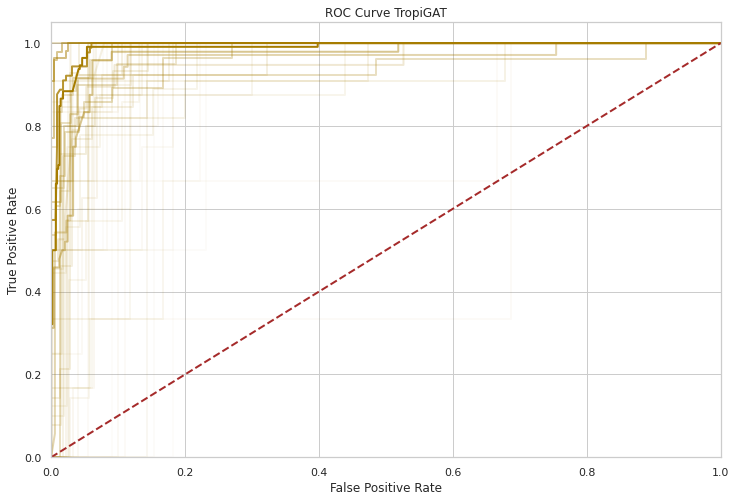

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_multiple_roc_curves(data_dict, curve_color):
    plt.figure(figsize=(12, 8))
    lw = 2
    sns.set(style="whitegrid")  # Set seaborn style
    for key, value in data_dict.items():
        fpr, tpr, _ = roc_curve(value['y_true'].cpu().numpy(), value['y_pred'].cpu().numpy())
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=lw, alpha=value['transparency']/100, color=curve_color, label=f'{key} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], color='brown', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve TropiGAT')
    #plt.legend(loc="lower right")
    plt.savefig('/media/concha-eloko/Linux/papers/PPT/figures_draft/prophage_ROC.TropiGAT.2002.svg', dpi = 500)
    plt.show()

plot_multiple_roc_curves(dico_pred_out, "#a67c00")
